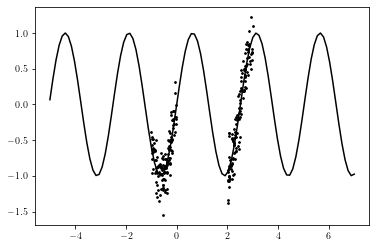

In [1]:
import os
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI')

import torch
torch.manual_seed(2)
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def mapping(x, noise=0.1):
    return torch.sin(2.5*x) + noise * torch.randn_like(x)


lower = -5
upper = 7

cluster_pos = [-1,2]
total_points = 256
cluster_points = total_points // len(cluster_pos)
x = torch.cat([mean + torch.rand(cluster_points) for mean in cluster_pos])
x_true = torch.linspace(lower, upper, 100)
data_noise = 0.2
y_true = mapping(x_true, noise=False)
y = mapping(x, noise=data_noise)


plt.figure()
plt.plot(x_true, y_true, color="black", label="True function")
plt.scatter(x,y, s=3, color="black")
plt.show()


In [2]:
class FC_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 100)
        self.nll = nn.Tanh()
    def forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        return h2

In [3]:
batch_size = 16
random_permutation = torch.randperm(len(x))
x_batch = torch.split(torch.unsqueeze(x[random_permutation], dim=1), batch_size)
y_batch =  torch.split(torch.unsqueeze(y[random_permutation], dim=1), batch_size)

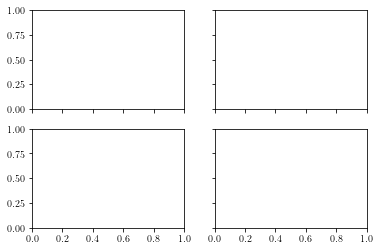

In [4]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
axs_flat = axs.flat;

In [5]:
from BasicExample.src.LLVI_network import LLVI_network, Log_likelihood_type
def test_model(model, ax, noise=True, laplace=False):
    # first add true data
    ax.plot(x_true, y_true, color="black", label="True function")
    ax.scatter(x,y, s=3, color="black")

    # predict
    test_x = torch.unsqueeze(torch.linspace(lower, upper, 300), dim=1)
    if laplace:
        y_mean, y_var = model(test_x)
        y_mean = torch.flatten(y_mean)
        y_std = torch.sqrt(torch.flatten(y_var))
    else:
        with torch.no_grad():
            y_mean, y_var = model.predict_regression(test_x, noise=noise)
        y_std = torch.sqrt(torch.diagonal(y_var))

    # visualize
    ax.plot(test_x, y_mean, color="royalblue", label="ML prediction/Mean") # mean
    # std
    ax.plot(test_x, y_mean+1.96*y_std, color="orange", label="$+-1.96 \cdot \sigma$")
    ax.plot(test_x, y_mean-1.96*y_std, color="orange")
    ax.fill_between(torch.squeeze(test_x),y_mean+1.96*y_std,y_mean-1.96*y_std, alpha=0.1, color="orange")
    
    # true noise
    if noise:
        y_std_true_noise = y_std - torch.exp(0.5 * model.data_log_var).item() + data_noise
        ax.plot(test_x, y_mean+1.96*y_std_true_noise, color="darkorange", label="$\sigma$ with true noise", linestyle="dashed")
        ax.plot(test_x, y_mean-1.96*y_std_true_noise, color="darkorange",  linestyle="dashed")
        noise_txt = f"Estimated data noise: {round(torch.exp(0.5 * model.data_log_var).item(), 2)}, true noise:{data_noise}"
        ax.set_xlabel(r'\begin{center}x\\*\textit{\small{' + noise_txt + r'}}\end{center}')
    else:
        ax.set_label("x")


    # labels
    ax.set_ylim(torch.min(y_true) - 2, torch.max(y_true) + 2)
    ax.set_title(model.model_config["kernel_name"])
    ax.set_ylabel("y")
    # plt.savefig(f"/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/presentations/shortpresentation_13_11/images/Regression/{model.model_config['kernel_name']}.jpg")
    # plt.show()


In [6]:
from BasicExample.src.LLVI_network import LLVI_network_diagonal
feature_extractor_diag = FC_Net()
diagonal_model = LLVI_network_diagonal(feature_extractor=feature_extractor_diag,
feature_dim=100, out_dim=1,
prior_mu=0, prior_log_var=-6,
init_ll_mu=0, init_ll_log_var=0,
tau=0.01, lr=1e-5,  bias=False, loss=Log_likelihood_type.MSE, wdecay=0.1, data_log_var = -1)

diagonal_model.train_without_VI(list(zip(x_batch, y_batch)), epochs=100)
diagonal_model.train_model(list(zip(x_batch, y_batch)), n_datapoints=total_points, epochs=500, samples=1, train_hyper=True, update_freq=5)
test_model(diagonal_model, ax = next(axs_flat))

Loss:2.43, Data LogLik:0.53, KL Loss:1.9: 100%|██████████| 500/500 [00:09<00:00, 52.89it/s]  


In [7]:
from BasicExample.src.LLVI_network import LLVI_network_full_Cov
feature_extractor_full_cov = FC_Net()
full_cov_model = LLVI_network_full_Cov(feature_extractor=feature_extractor_full_cov,
feature_dim=100, out_dim=1,
prior_mu=0, prior_log_var=-4,
init_ll_mu=0, init_ll_log_var=-0.5, init_ll_cov_scaling=0.1,
tau=0.01, lr=5e-5,  bias=False, loss=Log_likelihood_type.MSE, wdecay=0.1, data_log_var=-1)

# model.load_ml_estimate("P:/Dokumente/3 Uni/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/models/Regression/Pretrained/Baseline_wdecay_e-1")
full_cov_model.train_without_VI(list(zip(x_batch, y_batch)), epochs=100)
full_cov_model.train_model(list(zip(x_batch, y_batch)), n_datapoints=total_points, epochs=500, samples=5, train_hyper=True, update_freq=5)
test_model(full_cov_model, ax = next(axs_flat))

Loss:0.77, Data LogLik:0.52, KL Loss:0.25: 100%|██████████| 500/500 [00:15<00:00, 32.21it/s] 


In [8]:
from BasicExample.src.LLVI_network import LLVI_network_KFac
feature_extractor_kfac = FC_Net()
model_kfac = LLVI_network_KFac(feature_extractor=feature_extractor_kfac,
feature_dim=100, out_dim=1,
A_dim=10, B_dim=10,
prior_mu=0, prior_log_var=-6,
init_ll_mu=0, init_ll_cov_scaling=0.1,
tau=0.01, lr=1e-5,  bias=False, loss=Log_likelihood_type.MSE, wdecay=0.1, data_log_var = -1)

model_kfac.train_without_VI(list(zip(x_batch, y_batch)), epochs=100)
model_kfac.train_model(list(zip(x_batch, y_batch)), n_datapoints=total_points, epochs=500, samples=5, train_hyper=True, update_freq=5)
test_model(model_kfac, ax = next(axs_flat))

Loss:2.24, Data LogLik:0.61, KL Loss:1.63: 100%|██████████| 500/500 [00:28<00:00, 17.33it/s] 


In [9]:
feature_extractor_kfac_no_noise = FC_Net()
model_kfac_no_noise = LLVI_network_KFac(feature_extractor=feature_extractor_kfac_no_noise,
    feature_dim=100, out_dim=1,
    A_dim=10, B_dim=10,
    prior_mu=0, prior_log_var=-6,
    init_ll_mu=0, init_ll_cov_scaling=0.1,
    tau=0.01, lr=1e-5,  bias=False, loss=Log_likelihood_type.MSE_NO_NOISE, wdecay=0.1, data_log_var = None)
model_kfac_no_noise.train_without_VI(list(zip(x_batch, y_batch)), epochs=100)
model_kfac_no_noise.train_model(list(zip(x_batch, y_batch)), n_datapoints=total_points, epochs=500, samples=1, train_hyper=True, update_freq=5);

# test_model(model_kfac_no_noise, noise=False)


Loss:1.53, Data LogLik:0.16, KL Loss:1.37: 100%|██████████| 500/500 [00:24<00:00, 20.47it/s]


In [10]:
from laplace import Laplace
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [11]:
class FC_Net_Laplace(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)
        self.nll = nn.Tanh()
    def forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        return self.fc3(h2)

In [40]:
torch.manual_seed(2)
laplace_loader = DataLoader(TensorDataset(torch.unsqueeze(x, dim=-1), torch.unsqueeze(y, dim=-1)), batch_size=batch_size)
laplace_model = FC_Net_Laplace()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(laplace_model.parameters(), weight_decay=0.01, lr=1e-4)
for i in tqdm(range(300)):
    for X_batch, y_batch in laplace_loader:
        optimizer.zero_grad()
        loss = criterion(laplace_model(X_batch), y_batch)
        loss.backward()
        optimizer.step()

100%|██████████| 300/300 [00:04<00:00, 68.34it/s]


In [41]:
la = Laplace(laplace_model, 'regression', subset_of_weights='last_layer', hessian_structure='full')
la.model_config = {"kernel_name": "LLLaplace"}
la.fit(laplace_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

100%|██████████| 100/100 [00:00<00:00, 1281.56it/s]


In [42]:
axs_flat[-1].clear()
test_model(la, axs_flat[-1], noise=False, laplace=True)

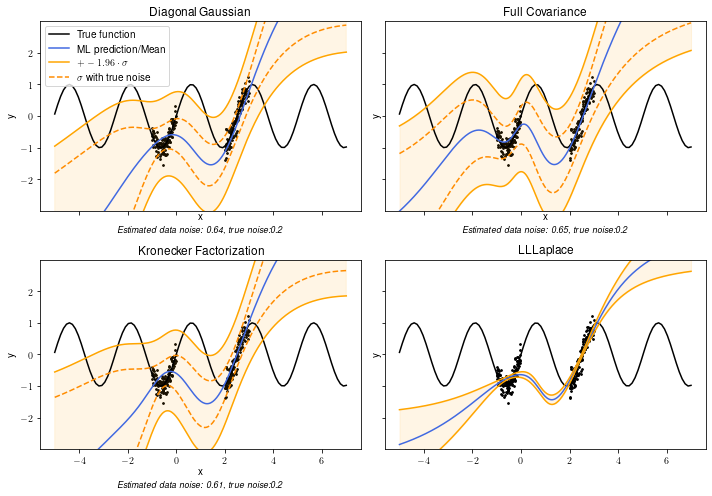

In [43]:
fig.set_figheight(7)
fig.set_figwidth(10)
axs_flat[0].legend()
fig.tight_layout()
fig.savefig(f"/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/presentations/shortpresentation_13_11/images/Regression/kernel_comparison.jpg")
fig